# Fruit and Vegetable Classification
https://www.kaggle.com/datasets/kritikseth/fruit-and-vegetable-image-recognition
https://www.kaggle.com/code/abdelrahman16/fruit-and-vegetable-classification
![fruit vegetable](https://i.imgur.com/KUAcIQD.jpeg)

# 1. Loading and preprocessing<a class="anchor" id="1"></a><a class="anchor" id="1"></a>

In [6]:
import cv2
import pandas as pd
import os

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Input, MaxPooling2D, Dropout, BatchNormalization, Reshape
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")

# Create a list with the filepaths for training and testing
train_dir = Path('../input/fruit-and-vegetable-image-recognition/train')
train_filepaths = list(train_dir.glob(r'**/*.jpg'))

test_dir = Path('../input/fruit-and-vegetable-image-recognition/test')
test_filepaths = list(test_dir.glob(r'**/*.jpg'))

val_dir = Path('../input/fruit-and-vegetable-image-recognition/validation')
val_filepaths = list(test_dir.glob(r'**/*.jpg'))

def proc_img(filepath):
    """ Create a DataFrame with the filepath and the labels of the pictures
    """

    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop = True)
    
    return df

train_df = proc_img(train_filepaths)
test_df = proc_img(test_filepaths)
val_df = proc_img(val_filepaths)

2024-09-10 12:31:37.467688: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-10 12:31:37.467908: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-10 12:31:37.641592: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
print('-- Training set --\n')
print(f'Number of pictures: {train_df.shape[0]}\n')
print(f'Number of different labels: {len(train_df.Label.unique())}\n')
print(f'Labels: {train_df.Label.unique()}')

-- Training set --

Number of pictures: 2780

Number of different labels: 36

Labels: ['soy beans' 'lettuce' 'apple' 'kiwi' 'cabbage' 'onion' 'pear' 'eggplant'
 'grapes' 'spinach' 'paprika' 'beetroot' 'cauliflower' 'pomegranate'
 'lemon' 'garlic' 'tomato' 'chilli pepper' 'sweetpotato' 'peas'
 'watermelon' 'sweetcorn' 'pineapple' 'corn' 'capsicum' 'jalepeno'
 'orange' 'bell pepper' 'turnip' 'raddish' 'mango' 'ginger' 'banana'
 'carrot' 'potato' 'cucumber']


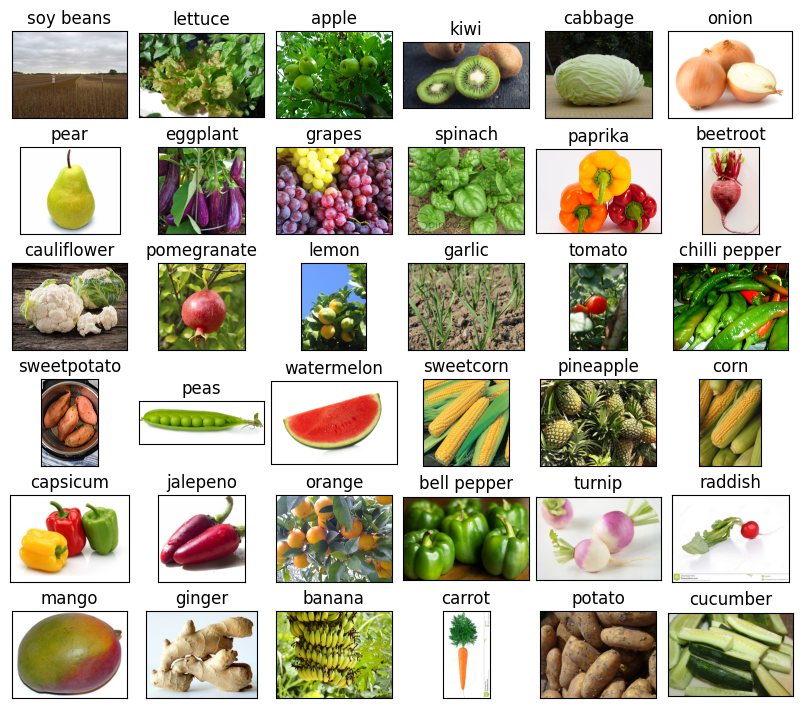

In [3]:
# Create a DataFrame with one Label of each category
df_unique = train_df.copy().drop_duplicates(subset=["Label"]).reset_index()

# Display some pictures of the dataset
fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(8, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.Filepath[i]))
    ax.set_title(df_unique.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

# 2. Load the Images with a generator and Data Augmentation<a class="anchor" id="2"></a>

In [4]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, validation_split=0.2)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator()

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    subset='training',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_images = train_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    subset='validation',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

Found 2224 validated image filenames belonging to 36 classes.
Found 66 validated image filenames belonging to 36 classes.


# 3. Train the model<a class="anchor" id="3"></a>

In [10]:
# Create the model
model = Sequential()
model.add(Input(shape=(224, 224, 3)))  # Input layer'ı açıkça belirt
model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(36, activation='softmax'))  # num_classes kullan

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Fit the model
history = model.fit(
    train_images,
    validation_data=val_images,
    batch_size=32,
    epochs=5
)

Epoch 1/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 113s 1s/step - accuracy: 0.0502 - loss: 3.5052 - val_accuracy: 0.0455 - val_loss: 3.0623
Epoch 2/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 95s 1s/step - accuracy: 0.1463 - loss: 2.9293 - val_accuracy: 0.2727 - val_loss: 2.3559
Epoch 3/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - accuracy: 0.2677 - loss: 2.4094 - val_accuracy: 0.3939 - val_loss: 1.9501
Epoch 4/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - accuracy: 0.3265 - loss: 2.2320 - val_accuracy: 0.4394 - val_loss: 1.6982
Epoch 5/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - accuracy: 0.4139 - loss: 1.9910 - val_accuracy: 0.5606 - val_loss: 1.4224


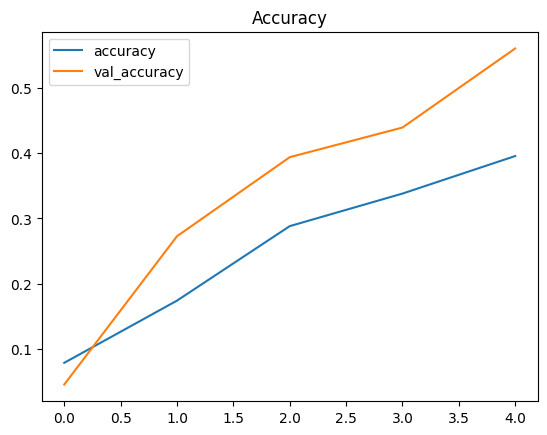

In [11]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

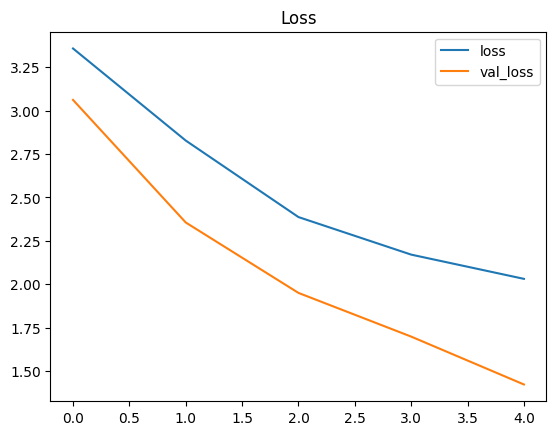

In [12]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

# 4. Visualize the result<a class="anchor" id="4"></a>

In [14]:
model.save('fruit_and_vegetable_model.h5')